# Check Version

In [1]:
import numpy as np
import cv2
print("NumPy version:", np.__version__)
print("OpenCV version:", cv2.__version__)

NumPy version: 1.26.4
OpenCV version: 4.11.0


In [2]:
import tensorflow as tf
print(tf.__version__)

2.19.0


In [3]:
import tensorflow as tf
from tensorflow.python.client import device_lib

print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU available:", tf.config.list_physical_devices('GPU'))
print(device_lib.list_local_devices())

TensorFlow version: 2.19.0
Built with CUDA: False
GPU available: []
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12404944484744628983
xla_global_id: -1
]


# Facial Expression Recognition

In [4]:
import os
import numpy as np
import sys
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import EfficientNetB0 ,EfficientNetB1 
from tensorflow.keras.layers import LSTM, Dense, Dropout , Flatten ,  TimeDistributed, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import mixed_precision
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.python.client import device_lib

# Pre-Processing Data (Video Extraction)

In [ ]:
import os, cv2, math, numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical


EMOTIONS = ["angry", "calm", "disgust", "fearful", "happy", "neutral", "sad", "surprised"]
EMO2ID = {e:i for i,e in enumerate(EMOTIONS)}

TARGET_FRAMES = 10
TARGET_SIZE = (224,224)  
RANDOM_STATE = 42

mp_face_mesh = mp.solutions.face_mesh.FaceMesh(
    static_image_mode=True, max_num_faces=1, refine_landmarks=False, min_detection_confidence=0.5
)

## MediaPipe-only: landmark → intensity z → neutral→apex → segment-max

In [ ]:
def detect_landmarks_points(img_bgr):
    """return np.array(468,2) หรือ None ถ้าไม่เจอหน้า"""
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    res = mp_face_mesh.process(img_rgb)
    if not res.multi_face_landmarks:
        return None
    h, w = img_bgr.shape[:2]
    pts = []
    for lm in res.multi_face_landmarks[0].landmark:
        pts.append([lm.x * w, lm.y * h])
    return np.array(pts, dtype=np.float32)

def iod(pts): 
    return np.linalg.norm(pts[33]-pts[263]) + 1e-6

def normalize_pts(pts):
    c = pts.mean(axis=0, keepdims=True)
    return (pts - c) / iod(pts)

def compute_intensity_z(landmarks_all, alpha=0.2, early_q=0.2):
    P = []
    for L in landmarks_all:
        if L is None: P.append(None)
        else:
            arr = L[:, :2] if L.shape[1] >= 2 else L
            P.append(normalize_pts(arr))
    T = len(P)
    if T == 0: 
        return np.zeros(0), 0, 0

    # movement
    mov = []
    for t in range(1, T):
        if P[t] is None or P[t-1] is None:
            mov.append(mov[-1] if mov else 0.0)
        else:
            mov.append(np.linalg.norm(P[t] - P[t-1], axis=1).mean())
    mov = np.array(mov, dtype=np.float32)

    # EMA + z-score
    ms = np.zeros_like(mov)
    for i,v in enumerate(mov): ms[i] = v if i==0 else alpha*v+(1-alpha)*ms[i-1]
    mov_z = (ms - ms.mean()) / (ms.std() + 1e-6)

    # neutral template 
    early_end = max(int(early_q*T), 1)
    cand = [t for t in range(early_end) if P[t] is not None]
    if cand:
        cand_sorted = sorted(cand, key=lambda t: mov_z[t-1] if t>0 else 0)[:max(5, len(cand)//3 or 1)]
        neutral_template = np.mean([P[t] for t in cand_sorted], axis=0)
    else:
        neutral_template = None

    # intensity
    intensity = []
    for t in range(T):
        if P[t] is None or neutral_template is None:
            intensity.append(intensity[-1] if intensity else 0.0)
        else:
            intensity.append(np.linalg.norm(P[t] - neutral_template, axis=1).mean())
    intensity = np.array(intensity, dtype=np.float32)

    # EMA + z-score for intensity
    is_ = np.zeros_like(intensity)
    for i,v in enumerate(intensity): is_[i] = v if i==0 else alpha*v+(1-alpha)*is_[i-1]
    int_z = (is_ - is_.mean())/(is_.std() + 1e-6)

    neutral_t = int(np.argmin(int_z[:early_end])) if T>0 else 0
    apex_t = int(np.argmax(int_z)) if T>0 else 0
    return int_z, neutral_t, apex_t

def select_segment_max(int_z, neutral_t, apex_t, k=10):
    start_t, end_t = sorted([neutral_t, apex_t])
    edges = np.linspace(start_t, end_t+1, k+1, dtype=int)
    picks = []
    for i in range(k):
        a, b = edges[i], edges[i+1]
        if b <= a: 
            picks.append(a); 
            continue
        seg = int_z[a:b]
        j = int(np.argmax(seg)) if len(seg)>0 else 0
        picks.append(a + j)
    if picks:
        picks[0] = neutral_t
    return sorted(picks)


In [ ]:
def extract_frames_from_video_mediapipe(video_path, max_frames=10, target_size=(224,224)):
    cap = cv2.VideoCapture(video_path)
    frames_bgr, landmarks_all = [], []
    while True:
        ok, f = cap.read()
        if not ok: break
        frames_bgr.append(f)
        landmarks_all.append(detect_landmarks_points(f))
    cap.release()

    if not any(L is not None for L in landmarks_all):
        return []   

    int_z, neutral_t, apex_t = compute_intensity_z(landmarks_all)
    selected = select_segment_max(int_z, neutral_t, apex_t, k=max_frames)

    out = []
    for t in selected:
        if landmarks_all[t] is None:
            continue
        img = cv2.cvtColor(frames_bgr[t], cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size)
        out.append(img)

    if len(out) == 0:
        return []
    if len(out) < max_frames:
        out += [out[-1].copy() for _ in range(max_frames - len(out))]

    return out[:max_frames]

# Data Loading and Labeling

In [ ]:
def load_data_from_directory_mediapipe(root_dir, max_frames=10, target_size=(224,224)):
    X, y, paths_skipped = [], [], []
    total_videos, used_videos = 0, 0

    for actor in sorted(os.listdir(root_dir)):
        actor_path = os.path.join(root_dir, actor)
        if not os.path.isdir(actor_path): 
            continue

        for emo in EMOTIONS:
            emo_path = os.path.join(actor_path, emo)
            if not os.path.isdir(emo_path):
                continue

            for fname in sorted(os.listdir(emo_path)):
                if not fname.lower().endswith(('.mp4', '.avi', '.mov', '.mkv')):
                    continue
                total_videos += 1
                vpath = os.path.join(emo_path, fname)
                frames = extract_frames_from_video_mediapipe(
                    vpath, max_frames=max_frames, target_size=target_size
                )
                if len(frames) != max_frames:
                    paths_skipped.append(vpath)
                    continue

                X.append(np.stack(frames, axis=0))   # (T,H,W,C)
                y.append(EMO2ID[emo])
                used_videos += 1

    X = np.array(X, dtype=np.uint8)   # (N,T,224,224,3), 
    y = np.array(y, dtype=np.int64)

    print(f"รวมวิดีโอทั้งหมด: {total_videos}, นำมาใช้ได้: {used_videos}, ถูกทิ้ง: {len(paths_skipped)}")
    if len(paths_skipped) > 0:
        print("ตัวอย่างวิดีโอที่ถูกทิ้ง (ไม่เจอหน้า/เฟรมไม่ครบ):")
        print("\n".join(paths_skipped[:10]), "..." if len(paths_skipped)>10 else "")

    return X, y

รวมวิดีโอทั้งหมด: 1440, นำมาใช้ได้: 1440, ถูกทิ้ง: 0
X shape: (1440, 10, 224, 224, 3) y shape: (1440,)
angry     : 192 ตัวอย่าง
calm      : 192 ตัวอย่าง
disgust   : 192 ตัวอย่าง
fearful   : 192 ตัวอย่าง
happy     : 192 ตัวอย่าง
neutral   : 96 ตัวอย่าง
sad       : 192 ตัวอย่าง
surprised : 192 ตัวอย่าง


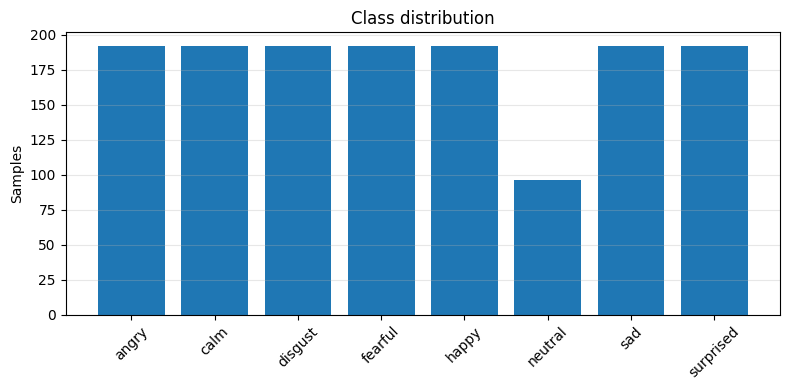

Train: (1008, 10, 224, 224, 3) Test: (432, 10, 224, 224, 3)


In [ ]:
ROOT_DIR = 'Dataset/RAVDESS_emotion_split'  

X, y = load_data_from_directory_mediapipe(ROOT_DIR, max_frames=TARGET_FRAMES, target_size=TARGET_SIZE)
print("X shape:", X.shape, "y shape:", y.shape)  # (N,T,224,224,3), (N,)

# class distribution
uni, cnt = np.unique(y, return_counts=True)
for emo_id, c in zip(uni, cnt):
    print(f"{EMOTIONS[emo_id]:10s}: {c} ตัวอย่าง")

plt.figure(figsize=(8,4))
plt.bar([EMOTIONS[i] for i in uni], cnt)
plt.xticks(rotation=45); plt.ylabel("Samples"); plt.title("Class distribution")
plt.grid(True, axis='y', alpha=0.3); plt.tight_layout(); plt.show()

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y
)
print("Train:", X_train.shape, "Test:", X_test.shape)

# Example Sample Data

index: 855, label: 1 (calm), video shape: (10, 224, 224, 3)


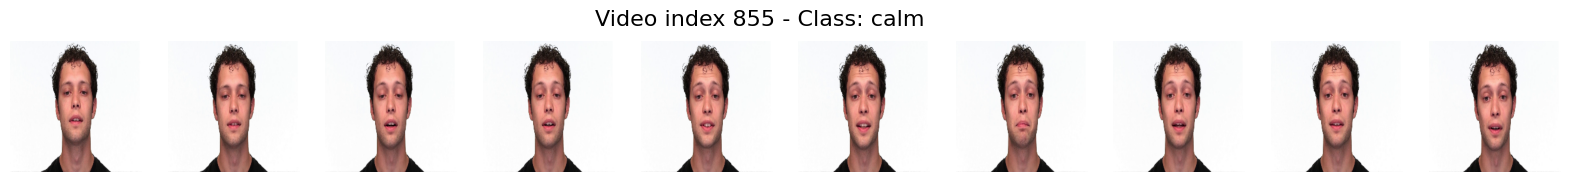

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# mapping label
emotion_classes = {
    0: "angry",
    1: "calm",
    2: "disgust",
    3: "fearful",
    4: "happy",
    5: "neutral",
    6: "surprise"
}

idx = np.random.randint(0, len(X))
sample_video = X[idx]   # (T, H, W, C)
sample_label = int(y[idx])

emotion_name = emotion_classes.get(sample_label, f"unknown({sample_label})")

print(f"index: {idx}, label: {sample_label} ({emotion_name}), video shape: {sample_video.shape}")

# แสดงทุกเฟรม
T = sample_video.shape[0]
cols = 10   
rows = int(np.ceil(T / cols))

plt.figure(figsize=(20, 2*rows))
for i in range(T):
    plt.subplot(rows, cols, i+1)
    plt.imshow(sample_video[i].astype("uint8"))
    plt.axis("off")
plt.suptitle(f"Video index {idx} - Class: {emotion_name}", fontsize=16)
plt.show()

# Prepare Data For Resnet50

In [ ]:
def prepare_data_for_resnet(X):
    """
    แปลงข้อมูลจาก (batch_size, timesteps, height, width, channels) 
    เป็น (batch_size, timesteps, height, width, 3) 
    โดยการตรวจสอบให้มี 3 ช่องสี (RGB)
    """
    if X.shape[-1] != 3:
        X = np.repeat(X, 3, axis=-1)  

# Prepare Data For EfficientB0

In [ ]:
def prepare_data_for_efficientnet(X, y):
    """
    X: (batch_size, timesteps, height, width, channels)
    y: (batch_size,)
    """
    
    X = tf.cast(X, tf.float32) / 255.0
    
    # ใช้ sparse labels
    y = tf.cast(y, tf.int32)  

    return X, y

# Feature Extraction with Pretrained CNN

## Resnet50

In [13]:
def build_model_Resnet(input_shape):
    model = Sequential()

    # ResNet50 layer 
    model.add(TimeDistributed(ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)))
    model.add(TimeDistributed(Flatten()))

    # LSTM layer
    model.add(LSTM(64, return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dropout(0.3))

    # Fully connected layer
    model.add(Dense(64, activation='relu'))
    model.add(Dense(8, activation='softmax')) 

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [14]:
model = build_model_Resnet((224, 224, 3)) 

In [15]:
model.build(input_shape=(None, 10, 224, 224, 3))

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┓
┃ Layer (type)            ┃ Output Shape      ┃   Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━┩
│ time_distributed        │ (None, 10, 7, 7,  │ 23,587,7… │
│ (TimeDistributed)       │ 2048)             │           │
├─────────────────────────┼───────────────────┼───────────┤
│ time_distributed_1      │ (None, 10,        │         0 │
│ (TimeDistributed)       │ 100352)           │           │
├─────────────────────────┼───────────────────┼───────────┤
│ lstm (LSTM)             │ (None, 10, 64)    │ 25,706,7… │
├─────────────────────────┼───────────────────┼───────────┤
│ dropout (Dropout)       │ (None, 10, 64)    │         0 │
├─────────────────────────┼───────────────────┼───────────┤
│ lstm_1 (LSTM)           │ (None, 64)        │    33,024 │
├─────────────────────────┼───────────────────┼───────────┤
│ dropout_1 (Dropout)     │ (None, 64)        │         0 │
├─────────────────────────┼───────────────────┼───────────┤
│ dense (Dense)           │ (None, 64)        │     4,160 │
├─────────────────────────┼───────────────────┼───────────┤
│ dense_1 (Dense)         │ (None, 8)         │       520 │
└─────────────────────────┴───────────────────┴───────────┘

 Total params: 49,332,168 (188.19 MB)

 Trainable params: 49,279,048 (187.98 MB)

 Non-trainable params: 53,120 (207.50 KB)

# TrainModel

In [ ]:
X_train_resnet = prepare_data_for_resnet(X_train)
X_test_resnet = prepare_data_for_resnet(X_test)

model = build_model_Resnet(input_shape=(224, 224, 3))  


checkpoint_callback = ModelCheckpoint(
    'best_ResNet50.h5',  
    monitor='val_loss',  
    save_best_only=True,  
    mode='min',  
    verbose=1  
)

# ฝึกโมเดล
history = model.fit(
    X_train_resnet, y_train,  
    epochs=10,  
    batch_size=32,  
    validation_data=(X_test_resnet, y_test),  
    callbacks=[checkpoint_callback] 
)

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.1314 - loss: 2.1064 
Epoch 1: val_loss improved from inf to 2.06719, saving model to best_ResNet50.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1188s 34s/step - accuracy: 0.1312 - loss: 2.1059 - val_accuracy: 0.1343 - val_loss: 2.0672
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.1346 - loss: 2.0762 
Epoch 2: val_loss improved from 2.06719 to 2.06242, saving model to best_ResNet50.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1074s 33s/step - accuracy: 0.1347 - loss: 2.0761 - val_accuracy: 0.1343 - val_loss: 2.0624
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.1172 - loss: 2.0741 
Epoch 3: val_loss did not improve from 2.06242
32/32 ━━━━━━━━━━━━━━━━━━━━ 1096s 34s/step - accuracy: 0.1176 - loss: 2.0740 - val_accuracy: 0.1343 - val_loss: 2.0629
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.1493 - loss: 2.0630 
Epoch 4: val_loss improved from 2.06242 to 2.06205, saving model to best_ResNet50.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1063s 33s/step - accuracy: 0.1485 - loss: 2.0632 - val_accuracy: 0.1343 - val_loss: 2.0621
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.1181 - loss: 2.0747 
Epoch 5: val_loss improved from 2.06205 to 2.06175, saving model to best_ResNet50.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1079s 33s/step - accuracy: 0.1184 - loss: 2.0745 - val_accuracy: 0.1319 - val_loss: 2.0618
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.1099 - loss: 2.0677 
Epoch 6: val_loss did not improve from 2.06175
32/32 ━━━━━━━━━━━━━━━━━━━━ 1106s 34s/step - accuracy: 0.1098 - loss: 2.0679 - val_accuracy: 0.1343 - val_loss: 2.0627
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.1566 - loss: 2.0616 
Epoch 7: val_loss did not improve from 2.06175
32/32 ━━━━━━━━━━━━━━━━━━━━ 1070s 33s/step - accuracy: 0.1560 - loss: 2.0617 - val_accuracy: 0.1343 - val_loss: 2.0624
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.1323 - loss: 2.0641 
Epoch 8: val_loss did not improve from 2.06175
32/32 ━━━━━━━━━━━━━━━━━━━━ 1086s 34s/step - accuracy: 0.1322 - loss: 2.0642 - val_accuracy: 0.1319 - val_loss: 2.0620
Epoch 9/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.1397 - loss: 2.0740 
Epoch 9: val_loss did not improve from 2.06175


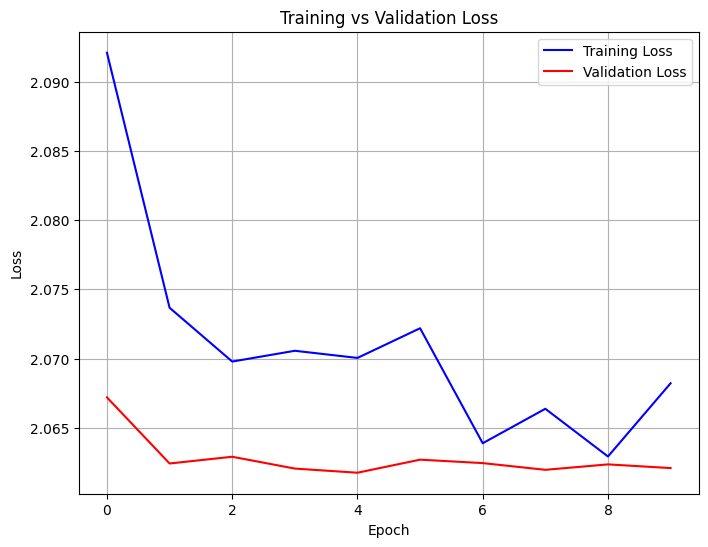

In [17]:
import matplotlib.pyplot as plt

# --- Loss ---
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], 'b-', label='Training Loss')
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

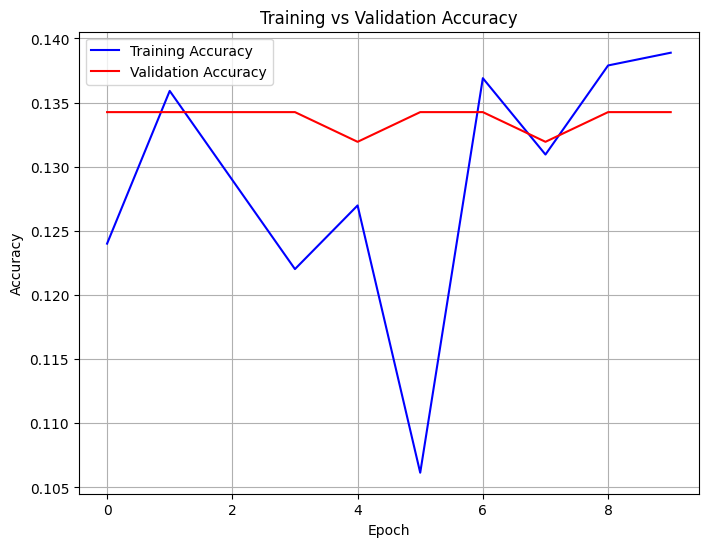

In [18]:
# --- Accuracy ---
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Resnet50 20 Epoch

In [19]:
from tensorflow.keras import backend as K
K.clear_session()
import gc
gc.collect()

0

In [ ]:

X_train_resnet = prepare_data_for_resnet(X_train)
X_test_resnet = prepare_data_for_resnet(X_test)

model = build_model_Resnet(input_shape=(224, 224, 3))  

checkpoint_callback = ModelCheckpoint(
    'best_ResNet50_20epoch.h5', 
    monitor='val_loss',  
    save_best_only=True,  
    mode='min',  
    verbose=1  
)

history = model.fit(
    X_train_resnet, y_train, 
    epochs=20,  
    batch_size=32,  
    validation_data=(X_test_resnet, y_test),  
    callbacks=[checkpoint_callback] 
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.1318 - loss: 2.0941 
Epoch 1: val_loss improved from inf to 2.06574, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1293s 37s/step - accuracy: 0.1317 - loss: 2.0939 - val_accuracy: 0.1319 - val_loss: 2.0657
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.1384 - loss: 2.0710 
Epoch 2: val_loss improved from 2.06574 to 2.06288, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1142s 35s/step - accuracy: 0.1386 - loss: 2.0710 - val_accuracy: 0.1343 - val_loss: 2.0629
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.1405 - loss: 2.0687 
Epoch 3: val_loss improved from 2.06288 to 2.05982, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1136s 35s/step - accuracy: 0.1401 - loss: 2.0688 - val_accuracy: 0.1644 - val_loss: 2.0598
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.1568 - loss: 2.0708 
Epoch 4: val_loss improved from 2.05982 to 2.05125, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1174s 36s/step - accuracy: 0.1567 - loss: 2.0704 - val_accuracy: 0.1597 - val_loss: 2.0513
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.1809 - loss: 2.0353 
Epoch 5: val_loss did not improve from 2.05125
32/32 ━━━━━━━━━━━━━━━━━━━━ 1126s 35s/step - accuracy: 0.1811 - loss: 2.0347 - val_accuracy: 0.1250 - val_loss: 2.0775
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.2050 - loss: 1.9756 
Epoch 6: val_loss improved from 2.05125 to 1.94650, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1141s 35s/step - accuracy: 0.2047 - loss: 1.9756 - val_accuracy: 0.2060 - val_loss: 1.9465
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.2181 - loss: 1.9478 
Epoch 7: val_loss did not improve from 1.94650
32/32 ━━━━━━━━━━━━━━━━━━━━ 1168s 36s/step - accuracy: 0.2187 - loss: 1.9470 - val_accuracy: 0.1088 - val_loss: 2.1879
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.2265 - loss: 1.9221 
Epoch 8: val_loss did not improve from 1.94650
32/32 ━━━━━━━━━━━━━━━━━━━━ 1103s 34s/step - accuracy: 0.2266 - loss: 1.9218 - val_accuracy: 0.1412 - val_loss: 2.0348
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.2309 - loss: 1.8663 
Epoch 9: val_loss did not improve from 1.94650
32/32 ━━━━━━━━━━━━━━━━━━━━ 1148s 36s/step - accuracy: 0.2310 - loss: 1.8671 - val_accuracy: 0.1921 - val_loss: 2.0820
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.2591 - loss: 1.8510 
Epoch 10: val_loss improved from 1.94650 to 1.

32/32 ━━━━━━━━━━━━━━━━━━━━ 1136s 35s/step - accuracy: 0.2589 - loss: 1.8513 - val_accuracy: 0.2431 - val_loss: 1.9204
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.2270 - loss: 1.8479 
Epoch 11: val_loss improved from 1.92036 to 1.83394, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1119s 35s/step - accuracy: 0.2272 - loss: 1.8485 - val_accuracy: 0.2431 - val_loss: 1.8339
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.2876 - loss: 1.7977 
Epoch 12: val_loss did not improve from 1.83394
32/32 ━━━━━━━━━━━━━━━━━━━━ 1120s 35s/step - accuracy: 0.2871 - loss: 1.7979 - val_accuracy: 0.1713 - val_loss: 2.2328
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.2866 - loss: 1.7929 
Epoch 13: val_loss improved from 1.83394 to 1.82020, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1128s 35s/step - accuracy: 0.2860 - loss: 1.7926 - val_accuracy: 0.2708 - val_loss: 1.8202
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.2530 - loss: 1.7654 
Epoch 14: val_loss improved from 1.82020 to 1.74829, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1133s 35s/step - accuracy: 0.2538 - loss: 1.7646 - val_accuracy: 0.2824 - val_loss: 1.7483
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.2843 - loss: 1.7945 
Epoch 15: val_loss did not improve from 1.74829
32/32 ━━━━━━━━━━━━━━━━━━━━ 1128s 35s/step - accuracy: 0.2843 - loss: 1.7951 - val_accuracy: 0.2523 - val_loss: 1.8219
Epoch 16/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.2949 - loss: 1.8144 
Epoch 16: val_loss improved from 1.74829 to 1.73699, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1138s 35s/step - accuracy: 0.2947 - loss: 1.8144 - val_accuracy: 0.2870 - val_loss: 1.7370
Epoch 17/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 34s/step - accuracy: 0.3024 - loss: 1.7096 
Epoch 17: val_loss improved from 1.73699 to 1.64221, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1155s 36s/step - accuracy: 0.3028 - loss: 1.7087 - val_accuracy: 0.3495 - val_loss: 1.6422
Epoch 18/20


In [ ]:

X_train_resnet = prepare_data_for_resnet(X_train)
X_test_resnet = prepare_data_for_resnet(X_test)

model = build_model_Resnet(input_shape=(224, 224, 3))  

checkpoint_callback = ModelCheckpoint(
    'best_ResNet50_20epoch.h5',  
    monitor='val_loss',  
    save_best_only=True,  
    mode='min',  
    verbose=1  
)

history = model.fit(
    X_train_resnet, y_train,  
    epochs=20,  
    batch_size=32,  
    validation_data=(X_test_resnet, y_test),  
    callbacks=[checkpoint_callback] 
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.1659 - loss: 2.0783 
Epoch 1: val_loss improved from inf to 2.06761, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1174s 33s/step - accuracy: 0.1654 - loss: 2.0785 - val_accuracy: 0.1319 - val_loss: 2.0676
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.1146 - loss: 2.0830 
Epoch 2: val_loss improved from 2.06761 to 2.06316, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1068s 33s/step - accuracy: 0.1146 - loss: 2.0828 - val_accuracy: 0.1319 - val_loss: 2.0632
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.1224 - loss: 2.0770 
Epoch 3: val_loss did not improve from 2.06316
32/32 ━━━━━━━━━━━━━━━━━━━━ 1097s 34s/step - accuracy: 0.1227 - loss: 2.0769 - val_accuracy: 0.1343 - val_loss: 2.0632
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.1207 - loss: 2.0731 
Epoch 4: val_loss did not improve from 2.06316
32/32 ━━━━━━━━━━━━━━━━━━━━ 1112s 34s/step - accuracy: 0.1208 - loss: 2.0730 - val_accuracy: 0.1343 - val_loss: 2.0632
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 33s/step - accuracy: 0.1434 - loss: 2.0721 
Epoch 5: val_loss improved from 2.06316 to 2.06234, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1125s 35s/step - accuracy: 0.1431 - loss: 2.0720 - val_accuracy: 0.1343 - val_loss: 2.0623
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.1245 - loss: 2.0649 
Epoch 6: val_loss did not improve from 2.06234
32/32 ━━━━━━━━━━━━━━━━━━━━ 1099s 34s/step - accuracy: 0.1246 - loss: 2.0651 - val_accuracy: 0.1343 - val_loss: 2.0626
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.1313 - loss: 2.0633 
Epoch 7: val_loss did not improve from 2.06234
32/32 ━━━━━━━━━━━━━━━━━━━━ 1094s 34s/step - accuracy: 0.1314 - loss: 2.0633 - val_accuracy: 0.1343 - val_loss: 2.0628
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.1327 - loss: 2.0642 
Epoch 8: val_loss did not improve from 2.06234
32/32 ━━━━━━━━━━━━━━━━━━━━ 1045s 32s/step - accuracy: 0.1324 - loss: 2.0643 - val_accuracy: 0.1319 - val_loss: 2.0632
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.1375 - loss: 2.0750 
Epoch 9: val_loss improved from 2.06234 to 2.06

32/32 ━━━━━━━━━━━━━━━━━━━━ 1087s 34s/step - accuracy: 0.1372 - loss: 2.0747 - val_accuracy: 0.1343 - val_loss: 2.0618
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.1256 - loss: 2.0584 
Epoch 10: val_loss did not improve from 2.06184
32/32 ━━━━━━━━━━━━━━━━━━━━ 1106s 34s/step - accuracy: 0.1255 - loss: 2.0586 - val_accuracy: 0.1319 - val_loss: 2.0629
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.1287 - loss: 2.0800 
Epoch 11: val_loss did not improve from 2.06184
32/32 ━━━━━━━━━━━━━━━━━━━━ 1065s 33s/step - accuracy: 0.1290 - loss: 2.0797 - val_accuracy: 0.1343 - val_loss: 2.0619
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.1279 - loss: 2.0641 
Epoch 12: val_loss did not improve from 2.06184
32/32 ━━━━━━━━━━━━━━━━━━━━ 1068s 33s/step - accuracy: 0.1279 - loss: 2.0642 - val_accuracy: 0.1319 - val_loss: 2.0625
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.1299 - loss: 2.0616 
Epoch 13: val_loss did not improve from 

32/32 ━━━━━━━━━━━━━━━━━━━━ 1085s 34s/step - accuracy: 0.1204 - loss: 2.0702 - val_accuracy: 0.1343 - val_loss: 2.0617
Epoch 16/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.1395 - loss: 2.0685 
Epoch 16: val_loss did not improve from 2.06172
32/32 ━━━━━━━━━━━━━━━━━━━━ 1045s 32s/step - accuracy: 0.1397 - loss: 2.0683 - val_accuracy: 0.1343 - val_loss: 2.0620
Epoch 17/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.1359 - loss: 2.0700 
Epoch 17: val_loss did not improve from 2.06172
32/32 ━━━━━━━━━━━━━━━━━━━━ 1078s 33s/step - accuracy: 0.1362 - loss: 2.0699 - val_accuracy: 0.1319 - val_loss: 2.0620
Epoch 18/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.1361 - loss: 2.0565 
Epoch 18: val_loss improved from 2.06172 to 2.06168, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1087s 34s/step - accuracy: 0.1362 - loss: 2.0567 - val_accuracy: 0.1343 - val_loss: 2.0617
Epoch 19/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.1544 - loss: 2.0617 
Epoch 19: val_loss did not improve from 2.06168
32/32 ━━━━━━━━━━━━━━━━━━━━ 1048s 33s/step - accuracy: 0.1537 - loss: 2.0618 - val_accuracy: 0.1343 - val_loss: 2.0618
Epoch 20/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.1310 - loss: 2.0643 
Epoch 20: val_loss did not improve from 2.06168
32/32 ━━━━━━━━━━━━━━━━━━━━ 1099s 34s/step - accuracy: 0.1312 - loss: 2.0643 - val_accuracy: 0.1343 - val_loss: 2.0617


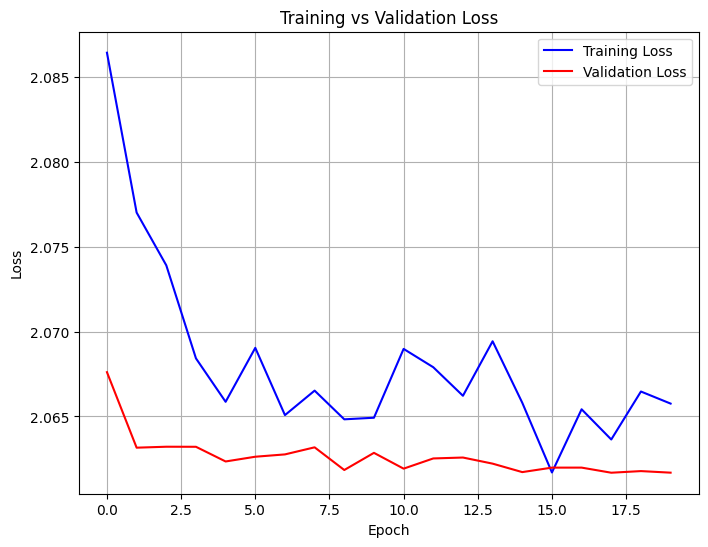

In [18]:
import matplotlib.pyplot as plt

# --- Loss ---
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], 'b-', label='Training Loss')
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

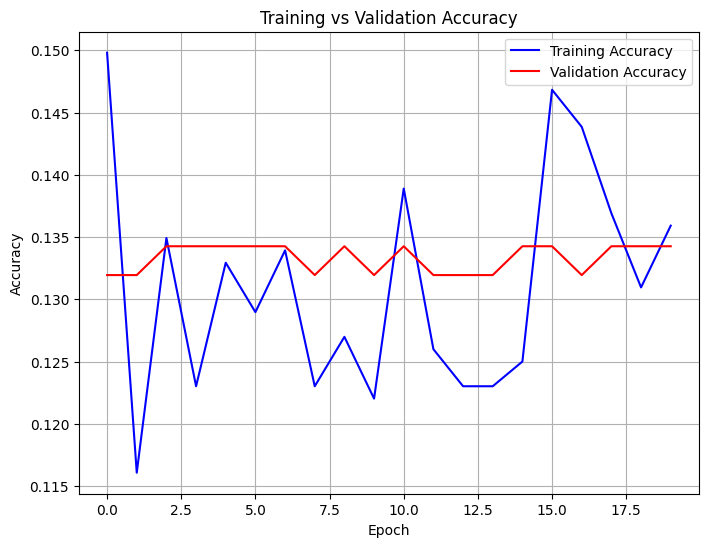

In [19]:
# --- Accuracy ---
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
from tensorflow.keras import backend as K
K.clear_session()
import gc
gc.collect()

0

# Resnet50 (epoch=20, Batch size = 32)

In [ ]:

X_train_resnet = prepare_data_for_resnet(X_train)
X_test_resnet = prepare_data_for_resnet(X_test)


model = build_model_Resnet(input_shape=(224, 224, 3))  

checkpoint_callback = ModelCheckpoint(
    'best_ResNet50_20epoch.h5',  
    monitor='val_loss', 
    save_best_only=True,  
    mode='min', 
    verbose=1  
)

history = model.fit(
    X_train_resnet, y_train,  
    epochs=20,  
    batch_size=32,  
    validation_data=(X_test_resnet, y_test),  
    callbacks=[checkpoint_callback] 
)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.1418 - loss: 2.0841 
Epoch 1: val_loss improved from inf to 2.06143, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1212s 35s/step - accuracy: 0.1419 - loss: 2.0840 - val_accuracy: 0.1644 - val_loss: 2.0614
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.1177 - loss: 2.0835 
Epoch 2: val_loss did not improve from 2.06143
32/32 ━━━━━━━━━━━━━━━━━━━━ 1073s 33s/step - accuracy: 0.1183 - loss: 2.0833 - val_accuracy: 0.1366 - val_loss: 2.0637
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.1635 - loss: 2.0360 
Epoch 3: val_loss improved from 2.06143 to 2.00607, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1043s 32s/step - accuracy: 0.1640 - loss: 2.0357 - val_accuracy: 0.1829 - val_loss: 2.0061
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.2038 - loss: 1.9849 
Epoch 4: val_loss did not improve from 2.00607
32/32 ━━━━━━━━━━━━━━━━━━━━ 1085s 34s/step - accuracy: 0.2039 - loss: 1.9847 - val_accuracy: 0.1898 - val_loss: 2.0354
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.2593 - loss: 1.9049 
Epoch 5: val_loss improved from 2.00607 to 1.95596, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1081s 33s/step - accuracy: 0.2595 - loss: 1.9048 - val_accuracy: 0.1944 - val_loss: 1.9560
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.2435 - loss: 1.8516 
Epoch 6: val_loss improved from 1.95596 to 1.90555, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1055s 33s/step - accuracy: 0.2435 - loss: 1.8523 - val_accuracy: 0.2245 - val_loss: 1.9056
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.2507 - loss: 1.8477 
Epoch 7: val_loss did not improve from 1.90555
32/32 ━━━━━━━━━━━━━━━━━━━━ 1059s 33s/step - accuracy: 0.2508 - loss: 1.8474 - val_accuracy: 0.2454 - val_loss: 1.9476
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.3089 - loss: 1.7991 
Epoch 8: val_loss improved from 1.90555 to 1.82360, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1088s 34s/step - accuracy: 0.3086 - loss: 1.7981 - val_accuracy: 0.2616 - val_loss: 1.8236
Epoch 9/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.3479 - loss: 1.7127 
Epoch 9: val_loss improved from 1.82360 to 1.79916, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1090s 34s/step - accuracy: 0.3474 - loss: 1.7126 - val_accuracy: 0.3102 - val_loss: 1.7992
Epoch 10/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 30s/step - accuracy: 0.3149 - loss: 1.7544 
Epoch 10: val_loss did not improve from 1.79916
32/32 ━━━━━━━━━━━━━━━━━━━━ 1046s 32s/step - accuracy: 0.3147 - loss: 1.7537 - val_accuracy: 0.2338 - val_loss: 1.9001
Epoch 11/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.3265 - loss: 1.6880 
Epoch 11: val_loss did not improve from 1.79916
32/32 ━━━━━━━━━━━━━━━━━━━━ 1065s 33s/step - accuracy: 0.3273 - loss: 1.6865 - val_accuracy: 0.2940 - val_loss: 1.8138
Epoch 12/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.3665 - loss: 1.5876 
Epoch 12: val_loss improved from 1.79916 to 1.59923, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1073s 33s/step - accuracy: 0.3669 - loss: 1.5868 - val_accuracy: 0.3704 - val_loss: 1.5992
Epoch 13/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.4309 - loss: 1.4843 
Epoch 13: val_loss did not improve from 1.59923
32/32 ━━━━━━━━━━━━━━━━━━━━ 1059s 33s/step - accuracy: 0.4303 - loss: 1.4853 - val_accuracy: 0.3333 - val_loss: 1.7378
Epoch 14/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.3991 - loss: 1.5403 
Epoch 14: val_loss did not improve from 1.59923
32/32 ━━━━━━━━━━━━━━━━━━━━ 1060s 33s/step - accuracy: 0.3997 - loss: 1.5385 - val_accuracy: 0.3287 - val_loss: 1.6561
Epoch 15/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.4441 - loss: 1.4753 
Epoch 15: val_loss did not improve from 1.59923
32/32 ━━━━━━━━━━━━━━━━━━━━ 1064s 33s/step - accuracy: 0.4443 - loss: 1.4745 - val_accuracy: 0.3657 - val_loss: 1.6934
Epoch 16/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.4569 - loss: 1.3879 
Epoch 16: val_loss improved from 1.59923

32/32 ━━━━━━━━━━━━━━━━━━━━ 1073s 33s/step - accuracy: 0.4562 - loss: 1.3896 - val_accuracy: 0.4005 - val_loss: 1.5650
Epoch 17/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.4664 - loss: 1.3444 
Epoch 17: val_loss improved from 1.56497 to 1.53252, saving model to best_ResNet50_20epoch.h5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1060s 33s/step - accuracy: 0.4659 - loss: 1.3454 - val_accuracy: 0.4190 - val_loss: 1.5325
Epoch 18/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.4627 - loss: 1.3379 
Epoch 18: val_loss did not improve from 1.53252
32/32 ━━━━━━━━━━━━━━━━━━━━ 1054s 33s/step - accuracy: 0.4625 - loss: 1.3400 - val_accuracy: 0.0671 - val_loss: 3.0558
Epoch 19/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 32s/step - accuracy: 0.4071 - loss: 1.6078 
Epoch 19: val_loss did not improve from 1.53252
32/32 ━━━━━━━━━━━━━━━━━━━━ 1087s 34s/step - accuracy: 0.4069 - loss: 1.6064 - val_accuracy: 0.3333 - val_loss: 1.6581
Epoch 20/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 31s/step - accuracy: 0.4972 - loss: 1.3723 
Epoch 20: val_loss did not improve from 1.53252
32/32 ━━━━━━━━━━━━━━━━━━━━ 1059s 33s/step - accuracy: 0.4972 - loss: 1.3721 - val_accuracy: 0.4329 - val_loss: 1.6856


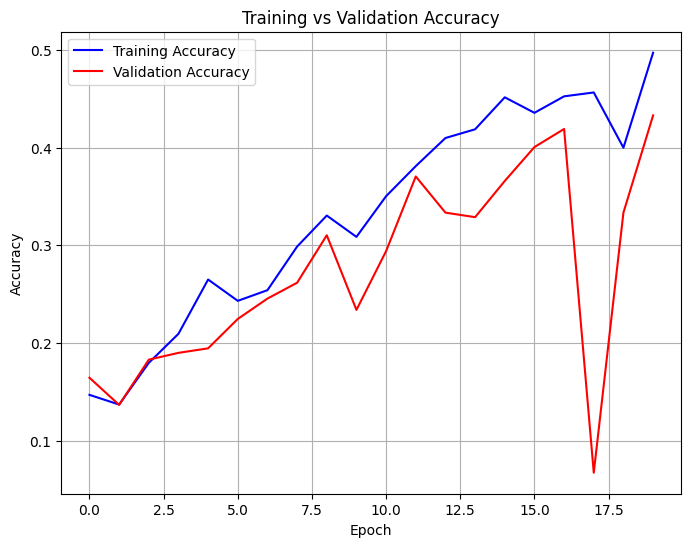

In [18]:
# --- Accuracy ---
plt.figure(figsize=(8,6))
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

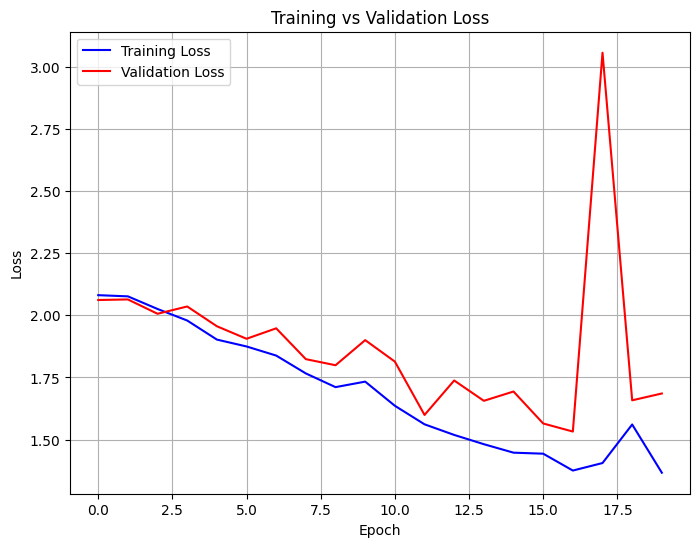

In [19]:
import matplotlib.pyplot as plt

# --- Loss ---
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'], 'b-', label='Training Loss')
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

14/14 - 60s - 4s/step - accuracy: 0.4329 - loss: 1.6856
Test accuracy: 0.43287035822868347
32/32 ━━━━━━━━━━━━━━━━━━━━ 162s 5s/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 59s 4s/step
Train Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.51      0.46       135
           1       0.50      0.68      0.58       135
           2       0.65      0.69      0.67       134
           3       0.33      0.30      0.31       134
           4       0.60      0.89      0.71       134
           5       0.48      0.36      0.41        67
           6       0.47      0.22      0.30       135
           7       0.34      0.21      0.26       134

    accuracy                           0.49      1008
   macro avg       0.47      0.48      0.46      1008
weighted avg       0.47      0.49      0.47      1008

Test Classification Report:
              precision    recall  f1-score   support

           0       0.34      0.37      0.35        57
           1 

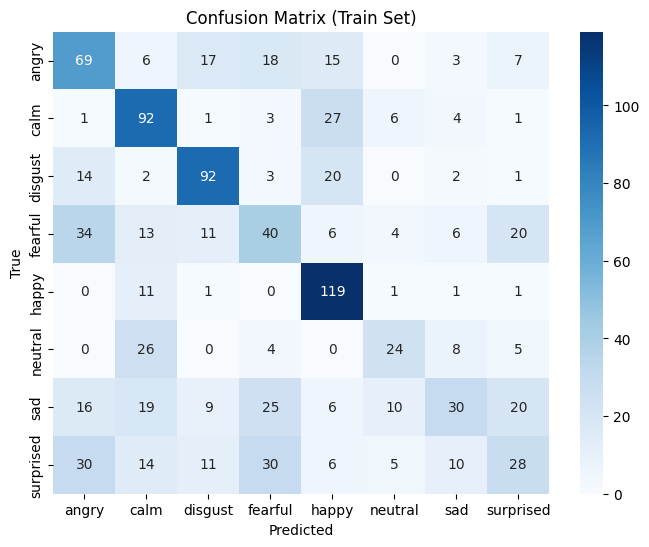

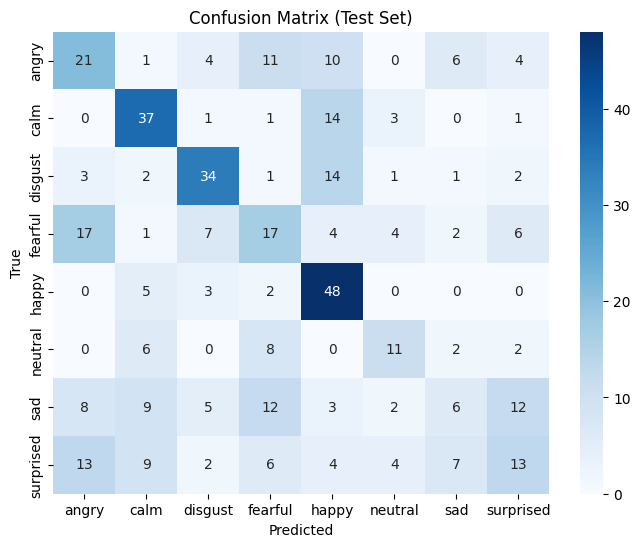

In [22]:
# กำหนดชื่อของอารมณ์ (emotions) ให้ตรงกับการจำแนก
emotions = ["angry", "calm", "disgust", "fearful", "happy", "neutral", "sad", "surprised"]
# ประเมินผลโมเดลบนชุดทดสอบ (Test)
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")  # แสดงค่า accuracy บนชุดทดสอบ

# ทำนายผลในชุดฝึกและชุดทดสอบ
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# แปลงการทำนายให้อยู่ในรูปแบบ label
y_train_pred_labels = np.argmax(y_train_pred, axis=1)
y_test_pred_labels = np.argmax(y_test_pred, axis=1)

# แสดง classification report สำหรับชุดฝึก
print("Train Classification Report:")
print(classification_report(y_train, y_train_pred_labels))

# แสดง classification report สำหรับชุดทดสอบ
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred_labels))

# สร้าง Confusion Matrix สำหรับชุดฝึก
cm_train = confusion_matrix(y_train, y_train_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues", xticklabels=emotions, yticklabels=emotions)
plt.title("Confusion Matrix (Train Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# สร้าง Confusion Matrix สำหรับชุดทดสอบ
cm_test = confusion_matrix(y_test, y_test_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues", xticklabels=emotions, yticklabels=emotions)
plt.title("Confusion Matrix (Test Set)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Test with EfficientNetB0

In [12]:
def prepare_data_for_efficientnet(X, y):
    """
    X: (batch_size, timesteps, height, width, channels)
    y: (batch_size,)
    """
    # แปลงข้อมูลเป็น float32 และทำ normalization
    X = tf.cast(X, tf.float32) / 255.0
    
    # ใช้ sparse labels
    y = tf.cast(y, tf.int32)  # แค่แปลงเป็น int32

    return X, y

## EfficientNet (ปรับ learning rate / Clipnorm)

In [ ]:
def build_model_EfficientNet(input_shape=(10, 224, 224, 3), num_classes=8 , model_EfficientNet=EfficientNetB0 , Dropout_num=0.3):
    model = Sequential()
    
    model.add(TimeDistributed(
        model_EfficientNet(weights='imagenet', include_top=False),
        input_shape=input_shape
    ))
    
    model.add(TimeDistributed(GlobalAveragePooling2D()))
    
    # ลดขนาด LSTM layers
    model.add(LSTM(64, return_sequences=True))  
    model.add(Dropout(Dropout_num))
    model.add(LSTM(64, return_sequences=False))  
    model.add(Dropout(Dropout_num))
    model.add(Dense(64, activation='relu'))     
    model.add(Dense(num_classes, activation='softmax'))
    
    # ใช้ sparse_categorical_crossentropy เพื่อไม่ต้อง one-hot encode
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
model = build_model_EfficientNet(input_shape=(10, 224, 224, 3), num_classes=8)
model.summary()

C:\Users\User\anaconda3\envs\tf219cpu\lib\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape       ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ time_distributed          │ (None, 10, 7, 7,   │  4,049,571 │
│ (TimeDistributed)         │ 1280)              │            │
├───────────────────────────┼────────────────────┼────────────┤
│ time_distributed_1        │ (None, 10, 1280)   │          0 │
│ (TimeDistributed)         │                    │            │
├───────────────────────────┼────────────────────┼────────────┤
│ lstm (LSTM)               │ (None, 10, 64)     │    344,320 │
├───────────────────────────┼────────────────────┼────────────┤
│ dropout (Dropout)         │ (None, 10, 64)     │          0 │
├───────────────────────────┼────────────────────┼────────────┤
│ lstm_1 (LSTM)             │ (None, 64)         │     33,024 │
├───────────────────────────┼────────────────────┼────────────┤
│ dropout_1 (Dropout)       │ (None, 64)         │          0 │
├───────────────────────────┼────────────────────┼────────────┤
│ dense (Dense)             │ (None, 64)         │      4,160 │
├───────────────────────────┼────────────────────┼────────────┤
│ dense_1 (Dense)           │ (None, 8)          │        520 │
└───────────────────────────┴────────────────────┴────────────┘

 Total params: 4,431,595 (16.91 MB)

 Trainable params: 4,389,572 (16.74 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [ ]:
datagen = ImageDataGenerator(rescale=1./255)  
X_train_seq, y_train_seq = prepare_data_for_efficientnet(X_train, y_train)
X_test_seq, y_test_seq = prepare_data_for_efficientnet(X_test, y_test)

model = build_model_EfficientNet(input_shape=(10, 224, 224, 3))

checkpoint_callback = ModelCheckpoint(
    'best_model_20epochEfficientnetB0.h5',  
    monitor='val_loss',  
    save_best_only=True, 
    mode='min', 
    verbose=1 
)


history = model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_test_seq, y_test_seq),
    epochs=10,
    batch_size=36, 
    callbacks=[checkpoint_callback]
)


Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 69s/step - accuracy: 0.2288 - loss: 1.9958  
Epoch 1: val_loss improved from inf to 2.09454, saving model to best_model_20epochEfficientnetB0.h5


28/28 ━━━━━━━━━━━━━━━━━━━━ 2141s 73s/step - accuracy: 0.2308 - loss: 1.9917 - val_accuracy: 0.0671 - val_loss: 2.0945
Epoch 2/10
